# Netbox initial REST API tests

* Just playing with the Netbox REST API and GUI in this notebook for now as I go through some of the [NetBoxLabs YouTube](https://www.youtube.com/@NetBoxLabs) videos
* I am running the Docker version of Netbox locally; rough instructions below for Mac:
```
brew install --cask docker
brew install docker-compose

git clone -b release https://github.com/netbox-community/netbox-docker.git
cd netbox-docker

# On
docker compose up -d
# Off
docker compose down

# Check Status:
docker ps
```

* Would like to try the `nornir_netbox` and `pynetbox` modules next


# Lab Setup with Netbox

* Creating a toy class to interact with Netbox below via API for learning and testing Netbox 101
* [NB device type libary](https://github.com/netbox-community/devicetype-library) can be used to import a ready made collection of device types into NetBox

## Topology
* Will be making heavy use of Logical-Systems
* Testing adding the devices to Netbox via API.
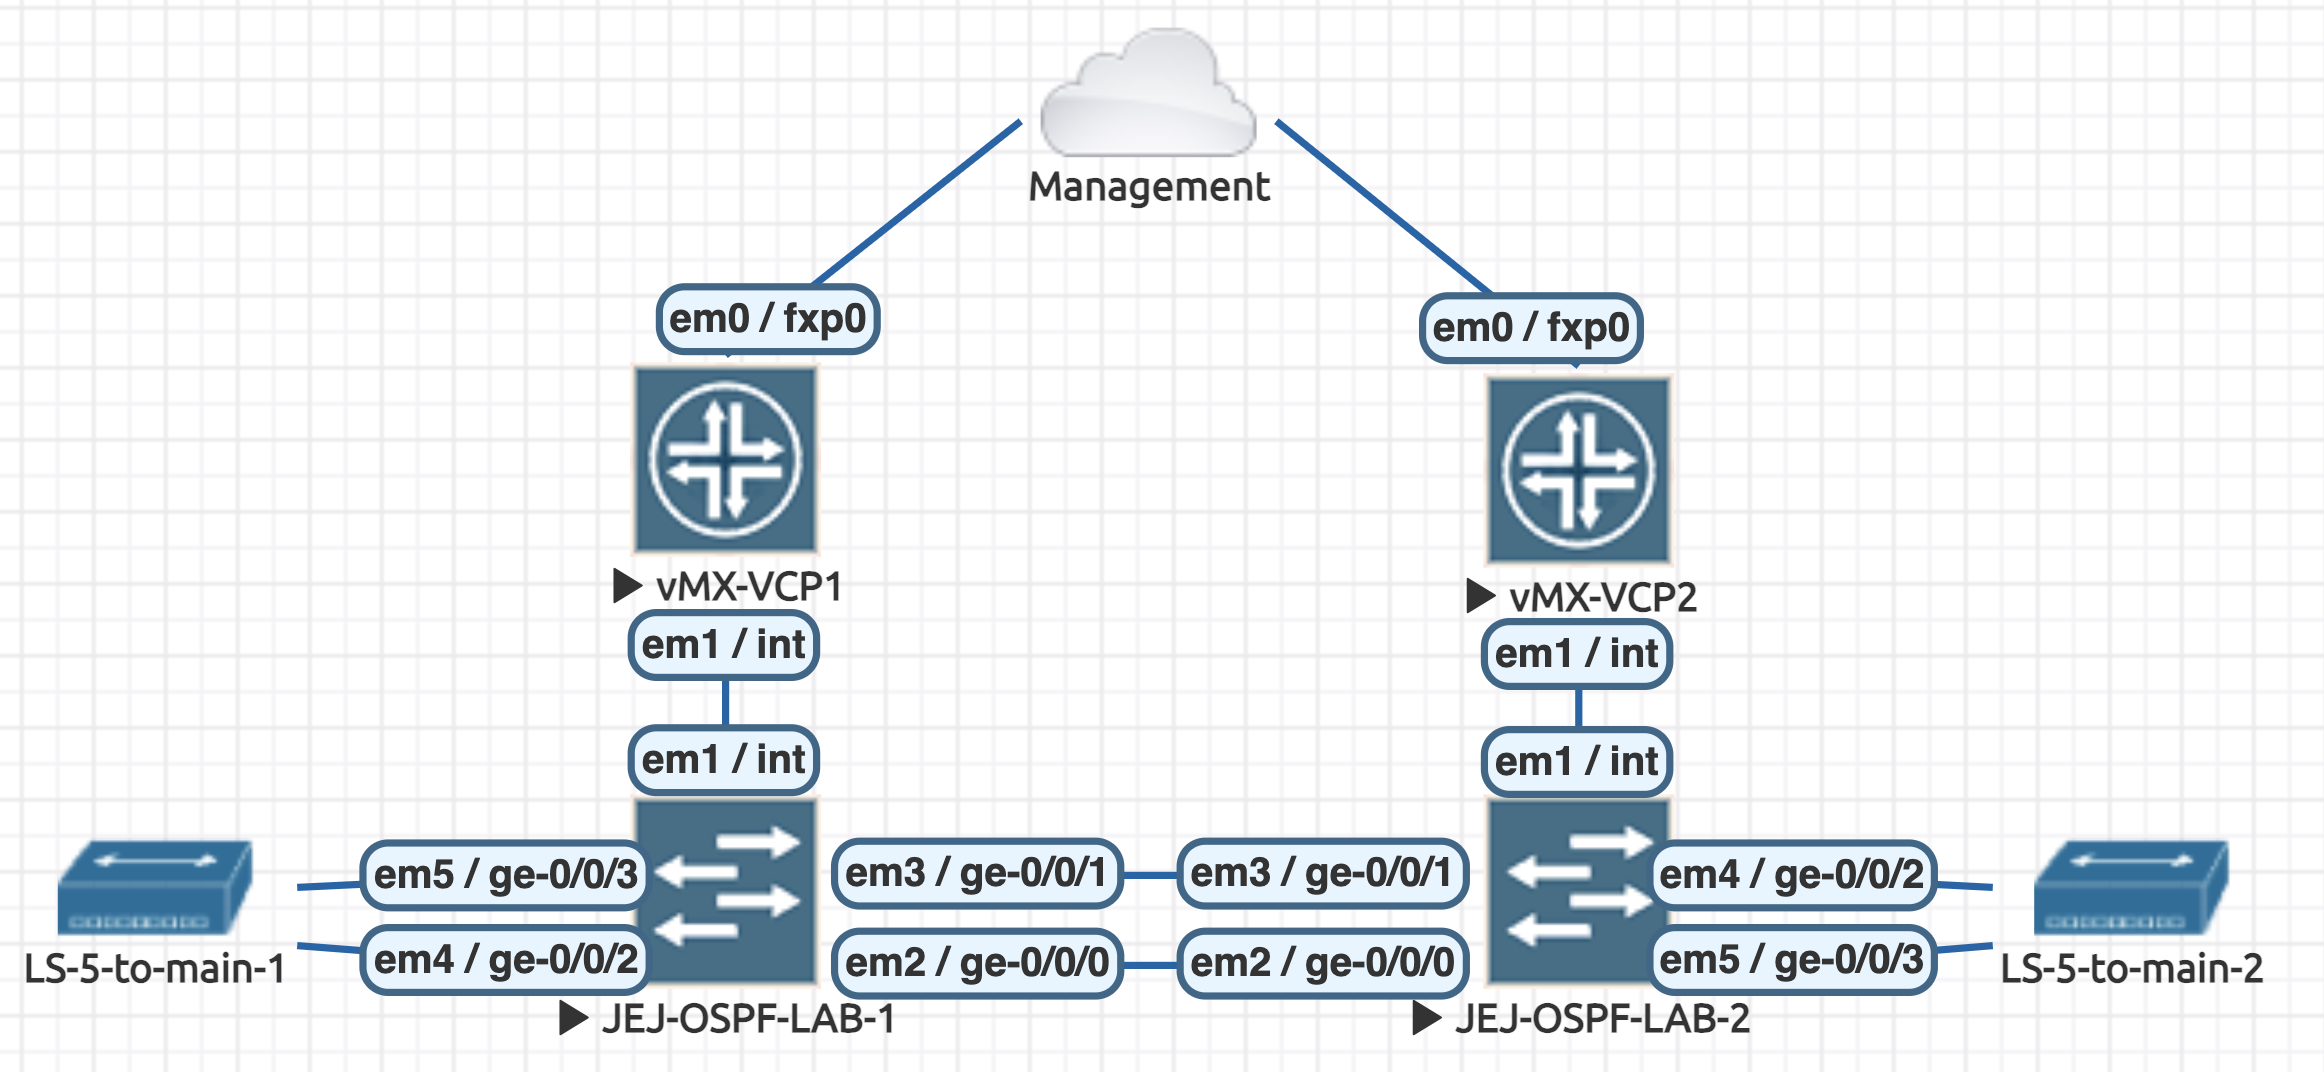

### Logical topology showing logical-systems configured
* IP addressing and subinterfaces added below with `pynetbox`
* Logical Diagram of logical systems and connection on vMX-OSPF-LAB-1 and vMX-OSPF-LAB-2.
* LS links on vMX-OSPF-LAB-1 will use the IP scheme 10.\<low>.\<high>.\<router_number>/24 for connecting links
    * Example: connection links addressing between LS-10 to LS-5 will be 10.5.10.10 and 10.5.10.5 respectively
* LS links on vMX-OSPF-LAB-2 will use the IP scheme 172.16\<high>\<low>.\<router_number>/24 for connecting links
    * Example: connection links addressing between LS-10 to LS-5 will be 172.16.105.10 and 172.16.105.5 respectively
* TODO: add addressing between the non-logical-systems; label link names; add bridges to connect logical system 5 and 10 to the main vMXs along with associated IP addressing
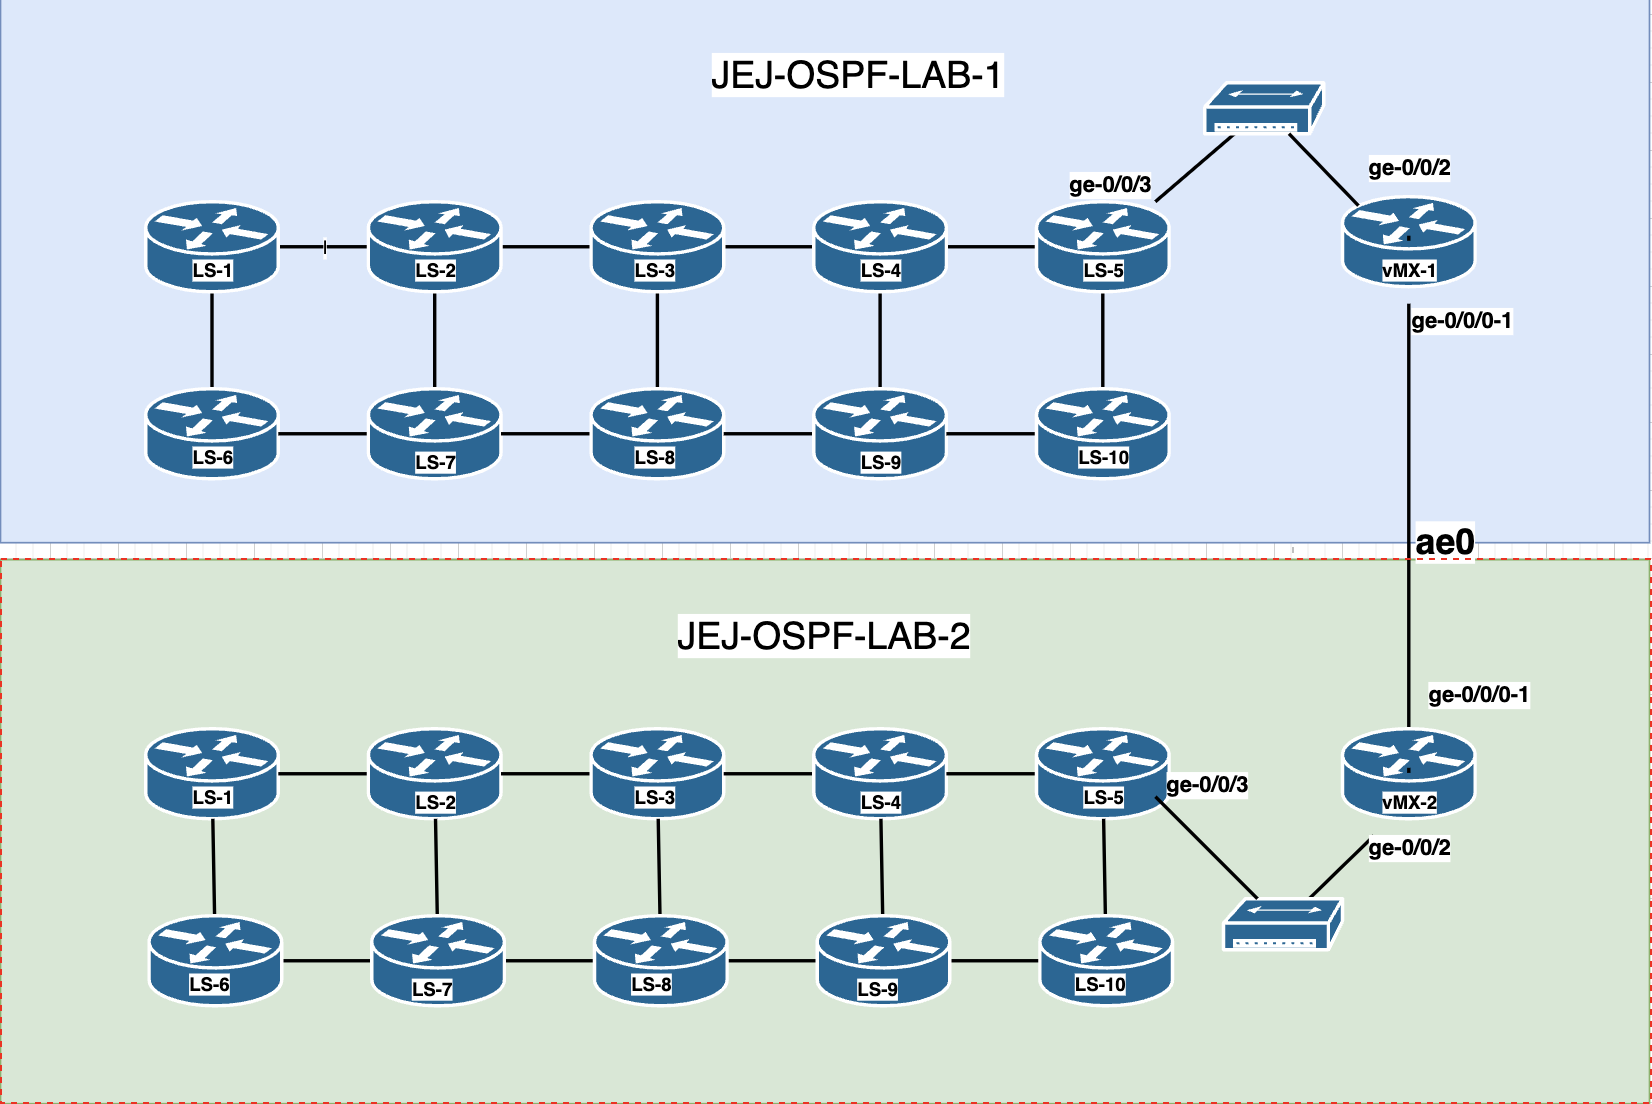

In [3]:
import os
import requests

class NB():
    def __init__(self, API_TOKEN=os.getenv("NETBOX_API_TOKEN"), url="http://localhost:8000/api"):
        self._API_TOKEN = API_TOKEN
        self._NETBOX_URL = url

    class NetBoxAPIError(Exception):
        """Custom exception for NetBox API errors"""
        pass
        
    def netbox_get(self, endpoint):
        headers = {
            "Authorization": f"Token {self._API_TOKEN}",
            "Content-Type": "application/json",
        }
        endpoint = f"{self._NETBOX_URL}/{endpoint}"
        response = requests.get(endpoint, headers=headers)
        if response.status_code == 200:
            response = response.json().get("results", [])
            return response
        else:
            raise NetBoxAPIError(f"Error: {response.status_code}")
            
    
    def netbox_post(self, endpoint, body):
        headers = {
            "Authorization": f"Token {self._API_TOKEN}",
            "Content-Type": "application/json",
        }
        endpoint = f"{self._NETBOX_URL}/{endpoint}"
        response = requests.post(endpoint, headers=headers, json=body)
        if str(response.status_code).startswith("2"):
            response = response.json()
            return response
        else:
            raise NetBoxAPIError(f"Error: {response.status_code}\n{response.text}")
    

    def get_manufacturers(self):
            manufacturers = self.netbox_get("/dcim/manufacturers/") 
            for m in manufacturers:
                print(f"ID: {m['id']} - Name: {m['name']} - Slug: {m['slug']}")
            
    def get_devices(self):
            response = self.netbox_get("/dcim/devices/") 
            return response
    
    def post_devices(self, body):
            response = self.netbox_post("/dcim/devices/", body) 
            return response
        
    def put_devices(self, body):
            response = self.netbox_post("/dcim/devices/", body) 
            return response
        
    def get_device_roles(self):
            response = self.netbox_get("/dcim/device-roles/") 
            return response
    
    def post_device_roles(self, body):
            response = self.netbox_post("/dcim/device-roles/", body) 
            return response
        
    def get_device_types(self):
            response = self.netbox_get("/dcim/device-types/") 
            return response
        
    def get_interfaces(self):
            response = self.netbox_get("/dcim/interfaces/") 
            return response
    
    def post_interfaces(self, body):
            response = self.netbox_post("/dcim/interfaces/", body) 
            return response
        
    def get_platforms(self):
            response = self.netbox_get("/dcim/platforms/") 
            return response
            
    def get_sites(self):
            response = self.netbox_get("/dcim/sites/") 
            return response


In [4]:
nb = NB()

In [5]:
nb.get_manufacturers() 

ID: 2 - Name: Cisco - Slug: cisco
ID: 3 - Name: Fortinet - Slug: fortinet
ID: 1 - Name: Juniper - Slug: juniper


In [21]:
ospf_device_roles = {
    "name": "OSPF-LAB",
    "slug": "ospf-lab",
    "vm_role": False ,
}
#netbox_post_device_role(body=ospf_device_role)
nb.get_device_roles()

[{'id': 4,
  'url': 'http://localhost:8000/api/dcim/device-roles/4/',
  'display_url': 'http://localhost:8000/dcim/device-roles/4/',
  'display': 'OSPF-LAB',
  'name': 'OSPF-LAB',
  'slug': 'ospf-lab',
  'color': '9e9e9e',
  'vm_role': False,
  'config_template': None,
  'description': '',
  'tags': [],
  'custom_fields': {},
  'created': '2025-02-23T13:31:49.956865Z',
  'last_updated': '2025-02-23T13:31:49.956877Z',
  'device_count': 2,
  'virtualmachine_count': 0},
 {'id': 1,
  'url': 'http://localhost:8000/api/dcim/device-roles/1/',
  'display_url': 'http://localhost:8000/dcim/device-roles/1/',
  'display': 'general_lab',
  'name': 'general_lab',
  'slug': 'general_lab',
  'color': '9e9e9e',
  'vm_role': True,
  'config_template': None,
  'description': '',
  'tags': [],
  'custom_fields': {},
  'created': '2025-02-22T21:44:59.963592Z',
  'last_updated': '2025-02-22T21:44:59.963611Z',
  'device_count': 0,
  'virtualmachine_count': 0}]

In [20]:
nb.get_platforms()

[{'id': 2,
  'url': 'http://localhost:8000/api/dcim/platforms/2/',
  'display_url': 'http://localhost:8000/dcim/platforms/2/',
  'display': 'ios',
  'name': 'ios',
  'slug': 'ios',
  'manufacturer': {'id': 2,
   'url': 'http://localhost:8000/api/dcim/manufacturers/2/',
   'display': 'Cisco',
   'name': 'Cisco',
   'slug': 'cisco',
   'description': ''},
  'config_template': None,
  'description': '',
  'tags': [],
  'custom_fields': {},
  'created': '2025-02-22T21:43:07.058666Z',
  'last_updated': '2025-02-22T21:43:07.058686Z',
  'device_count': 0,
  'virtualmachine_count': 0},
 {'id': 1,
  'url': 'http://localhost:8000/api/dcim/platforms/1/',
  'display_url': 'http://localhost:8000/dcim/platforms/1/',
  'display': 'junos',
  'name': 'junos',
  'slug': 'junos',
  'manufacturer': {'id': 1,
   'url': 'http://localhost:8000/api/dcim/manufacturers/1/',
   'display': 'Juniper',
   'name': 'Juniper',
   'slug': 'juniper',
   'description': ''},
  'config_template': None,
  'description': '',

### Device-Type YAML data for vMX
* Adjusted one of the yaml files from the netbox community lab device-type folder to fit the lab
```
---
manufacturer: Juniper
model: vMX
slug: juniper-vMX
part_number: vMX
u_height: 1
front_image: true
rear_image: true
is_full_depth: false
comments: '[Juniper vMX Data Sheet](https://www.juniper.net/content/dam/www/assets/datasheets/us/en/routers/vmx-virtual-router-datasheet.pdf)'
interfaces:
  - name: fxp0
    type: 1000base-t
    mgmt_only: true
  - name: ge-0/0/0
    type: 1000base-t
  - name: ge-0/0/1
    type: 1000base-t
  - name: ge-0/0/2
    type: 1000base-t
  - name: ge-0/0/3
    type: 1000base-t
  - name: ge-0/0/4
    type: 1000base-t
  - name: ge-0/0/5
    type: 1000base-t
  - name: ge-0/0/6
    type: 1000base-t
  - name: ge-0/0/7
    type: 1000base-t
  - name: ge-0/0/8
    type: 1000base-t
  - name: ge-0/0/9
    type: 1000base-t
console-ports:
  - name: Console
    type: rj-45
```
### Device-Type YAML data for Logical-Systems on the vMXs
* Not sure if this is the best way to add this, but works for labbing for now)
* Doesn't really make senses to add them as VRFs as I will likely use them to run VRFs
* Adjusted one of the yaml files from the netbox community lab device-type folder to fit the lab
```
---
manufacturer: Juniper
model: vMX-LS
slug: juniper-vMX-LS
part_number: vMX
u_height: 1
front_image: true
rear_image: true
is_full_depth: false
comments: '[Juniper vMX Data Sheet](https://www.juniper.net/content/dam/www/assets/datasheets/us/en/routers/vmx-virtual-router-datasheet.pdf)'
```

In [44]:
device_types = nb.get_device_types()
for dt in device_types:
    print(f"ID: {dt['id']}; Display Name: {dt['display']}")

ID: 2; Display Name: vMX
ID: 3; Display Name: vMX-LS


In [40]:
ospf_lab_1_router = {
  "name": "JEJ-OSPF-LAB-1",
  "device_role": 4,
  "device_type": 2,
  "role": 4 ,
  "platform": 1,
  "site": 1,
  "status": "active",
}
#nb.post_devices(body=ospf_lab_1_router)

In [37]:
ospf_lab_2_router = {
  "name": "JEJ-OSPF-LAB-2",
  "device_role": 4,
  "device_type": 2,
  "role": 4 ,
  "platform": 1,
  "site": 1,
  "status": "active",
}
#nb.post_devices(body=ospf_lab_2_router)

In [34]:
#nb.get_sites()

In [60]:
for i in range(1,3):
    for j in range(1,11): 
        ospf_lab_router_ls = {
          "name": f"JEJ-OSPF-LAB-{i}-LS-{j}",
          "device_role": 4,
          "device_type": 3,   # Type-3 for vMX-LS
          "role": 4 ,
          "platform": 1,
          "site": 1,
          "status": "active",
        }
        nb.post_devices(body=ospf_lab_router_ls)

In [61]:
devices = nb.get_devices()
for device in devices:
    print(f'name: {device["name"]}; id: {device["id"]}; type: {device["device_type"]["display"]}')

name: JEJ-OSPF-LAB-1; id: 1; type: vMX
name: JEJ-OSPF-LAB-1-LS-1; id: 43; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-2; id: 44; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-3; id: 45; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-4; id: 46; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-5; id: 47; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-6; id: 48; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-7; id: 49; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-8; id: 50; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-9; id: 51; type: vMX-LS
name: JEJ-OSPF-LAB-1-LS-10; id: 52; type: vMX-LS
name: JEJ-OSPF-LAB-2; id: 2; type: vMX
name: JEJ-OSPF-LAB-2-LS-1; id: 53; type: vMX-LS
name: JEJ-OSPF-LAB-2-LS-2; id: 54; type: vMX-LS
name: JEJ-OSPF-LAB-2-LS-3; id: 55; type: vMX-LS
name: JEJ-OSPF-LAB-2-LS-4; id: 56; type: vMX-LS
name: JEJ-OSPF-LAB-2-LS-5; id: 57; type: vMX-LS
name: JEJ-OSPF-LAB-2-LS-6; id: 58; type: vMX-LS
name: JEJ-OSPF-LAB-2-LS-7; id: 59; type: vMX-LS
name: JEJ-OSPF-LAB-2-LS-8; id: 60; type: vMX-LS
name: JEJ-OSPF-LAB-2-LS-9; id: 61; type: vMX-LS
name: JEJ

# Experimenting with pynetbox

* I got this code to work (add logical-tunnels subinterfaces and IPs to netbox), but seems a bit too complicated (and brittle) for my intent. Works for the lab for now though and I will look for better options later.

In [6]:
import pynetbox

In [7]:
API_TOKEN=os.getenv("NETBOX_API_TOKEN")
url="http://localhost:8000"
pynb = pynetbox.api(url, token=API_TOKEN)
devices = pynb.dcim.devices.all()
print(list(devices))

[JEJ-OSPF-LAB-1, JEJ-OSPF-LAB-1-LS-1, JEJ-OSPF-LAB-1-LS-2, JEJ-OSPF-LAB-1-LS-3, JEJ-OSPF-LAB-1-LS-4, JEJ-OSPF-LAB-1-LS-5, JEJ-OSPF-LAB-1-LS-6, JEJ-OSPF-LAB-1-LS-7, JEJ-OSPF-LAB-1-LS-8, JEJ-OSPF-LAB-1-LS-9, JEJ-OSPF-LAB-1-LS-10, JEJ-OSPF-LAB-2, JEJ-OSPF-LAB-2-LS-1, JEJ-OSPF-LAB-2-LS-2, JEJ-OSPF-LAB-2-LS-3, JEJ-OSPF-LAB-2-LS-4, JEJ-OSPF-LAB-2-LS-5, JEJ-OSPF-LAB-2-LS-6, JEJ-OSPF-LAB-2-LS-7, JEJ-OSPF-LAB-2-LS-8, JEJ-OSPF-LAB-2-LS-9, JEJ-OSPF-LAB-2-LS-10]


In [10]:
# Generate the lt-0/0/0.x tunnels and the IP addresses and add to Netbox

connections = [
    ("JEJ-OSPF-LAB-1-LS-1", "JEJ-OSPF-LAB-1-LS-2"),
    ("JEJ-OSPF-LAB-1-LS-1", "JEJ-OSPF-LAB-1-LS-6"),
    ("JEJ-OSPF-LAB-1-LS-2", "JEJ-OSPF-LAB-1-LS-3"),
    ("JEJ-OSPF-LAB-1-LS-2", "JEJ-OSPF-LAB-1-LS-7"),
    ("JEJ-OSPF-LAB-1-LS-3", "JEJ-OSPF-LAB-1-LS-4"),
    ("JEJ-OSPF-LAB-1-LS-3", "JEJ-OSPF-LAB-1-LS-8"),
    ("JEJ-OSPF-LAB-1-LS-4", "JEJ-OSPF-LAB-1-LS-5"),
    ("JEJ-OSPF-LAB-1-LS-4", "JEJ-OSPF-LAB-1-LS-9"),
    ("JEJ-OSPF-LAB-1-LS-5", "JEJ-OSPF-LAB-1-LS-10"),
    ("JEJ-OSPF-LAB-1-LS-6", "JEJ-OSPF-LAB-1-LS-7"),
    ("JEJ-OSPF-LAB-1-LS-7", "JEJ-OSPF-LAB-1-LS-8"),
    ("JEJ-OSPF-LAB-1-LS-8", "JEJ-OSPF-LAB-1-LS-9"),
    ("JEJ-OSPF-LAB-1-LS-9", "JEJ-OSPF-LAB-1-LS-10"),
    ("JEJ-OSPF-LAB-2-LS-1", "JEJ-OSPF-LAB-2-LS-2"),
    ("JEJ-OSPF-LAB-2-LS-1", "JEJ-OSPF-LAB-2-LS-6"),
    ("JEJ-OSPF-LAB-2-LS-2", "JEJ-OSPF-LAB-2-LS-3"),
    ("JEJ-OSPF-LAB-2-LS-2", "JEJ-OSPF-LAB-2-LS-7"),
    ("JEJ-OSPF-LAB-2-LS-3", "JEJ-OSPF-LAB-2-LS-4"),
    ("JEJ-OSPF-LAB-2-LS-3", "JEJ-OSPF-LAB-2-LS-8"),
    ("JEJ-OSPF-LAB-2-LS-4", "JEJ-OSPF-LAB-2-LS-5"),
    ("JEJ-OSPF-LAB-2-LS-4", "JEJ-OSPF-LAB-2-LS-9"),
    ("JEJ-OSPF-LAB-2-LS-5", "JEJ-OSPF-LAB-2-LS-10"),
    ("JEJ-OSPF-LAB-2-LS-6", "JEJ-OSPF-LAB-2-LS-7"),
    ("JEJ-OSPF-LAB-2-LS-7", "JEJ-OSPF-LAB-2-LS-8"),
    ("JEJ-OSPF-LAB-2-LS-8", "JEJ-OSPF-LAB-2-LS-9"),
    ("JEJ-OSPF-LAB-2-LS-9", "JEJ-OSPF-LAB-2-LS-10"),
]

def generate_lt_interface_names(ls_a, ls_b):
    """
    Take the connections and return the lt-0/0/0.x interfaces for the interconnection between the two logical-systems.
    Returns a tuple where the first entry is the lower-numbered LT interface and the second entry is the higher-numbered
    LT interface.
    For example LS-1 to LS-2 returns ("lt-0/0/0.12", "lt-0/0/0.21")
    """
    num_a = int(ls_a.split('-LS-')[-1])
    num_b = int(ls_b.split('-LS-')[-1])
    if num_a < num_b:
        return (f"lt-0/0/0.{min(num_a, num_b)}{max(num_a, num_b)}", f"lt-0/0/0.{max(num_a, num_b)}{min(num_a, num_b)}")
    return (f"lt-0/0/0.{max(num_a, num_b)}{min(num_a, num_b)}", f"lt-0/0/0.{min(num_a, num_b)}{max(num_a, num_b)}")

def generate_ips(ls_a, ls_b):
    """
    Take the connections and return the corresponding IPs to use on the interfaces created via `generate_lt_interface_names`
    """
    num_a = int(ls_a.split('-LS-')[-1])
    num_b = int(ls_b.split('-LS-')[-1])
    if "LAB-1" in ls_a:
        return f"10.{min(num_a, num_b)}.{max(num_a, num_b)}.{num_a}", f"10.{min(num_a, num_b)}.{max(num_a, num_b)}.{num_b}"
    else:
        return f"172.16.{max(num_a, num_b)}{min(num_a, num_b)}.{num_a}", f"172.16.{max(num_a, num_b)}{min(num_a, num_b)}.{num_b}"

# Generate the lt-0/0/0.x tunnels and the IP addresses and add to Netbox
for connection in connections:
    lt_names = generate_lt_interface_names(*connection)
    lt_ips = generate_ips(*connection)
    
    device_a = pynb.dcim.devices.get(name=connection[0])
    device_b = pynb.dcim.devices.get(name=connection[1])
    for index, device in enumerate([device_a, device_b]):
        if device:
            #print(index, device, lt_names[index], lt_ips[index]) # quick debug print
            try:
                interface = pynb.dcim.interfaces.get(device_id=device.id, name=lt_names[index])
                if not interface:
                    interface = pynb.dcim.interfaces.create(
                        {
                            "device": device.id,
                            "name": lt_names[index],
                            "type": "virtual",
                        }
                    )
                else:
                    print(f"Interface {lt_names[index]} already exists on {device}.")
                    
                existing_ip = pynb.ipam.ip_addresses.get(address=f"{lt_ips[index]}/24")
                if not existing_ip:
                    pynb.ipam.ip_addresses.create(
                        {
                            "address": f"{lt_ips[index]}/24",
                            "assigned_object_type": "dcim.interface",
                            "assigned_object_id": interface.id,
                        }
                    )
                else:
                    print(f"IP {lt_ips[index]}/24 already exists.")
            except Exception as e:
                print(e)
        else:
            print(f"Device {ls} not found in NetBox.")

Interface lt-0/0/0.12 already exists on JEJ-OSPF-LAB-1-LS-1.
Interface lt-0/0/0.21 already exists on JEJ-OSPF-LAB-1-LS-2.
Interface lt-0/0/0.16 already exists on JEJ-OSPF-LAB-1-LS-1.
IP 10.1.6.1/24 already exists.
Interface lt-0/0/0.61 already exists on JEJ-OSPF-LAB-1-LS-6.
IP 10.1.6.6/24 already exists.
Interface lt-0/0/0.23 already exists on JEJ-OSPF-LAB-1-LS-2.
IP 10.2.3.2/24 already exists.
Interface lt-0/0/0.32 already exists on JEJ-OSPF-LAB-1-LS-3.
IP 10.2.3.3/24 already exists.
Interface lt-0/0/0.27 already exists on JEJ-OSPF-LAB-1-LS-2.
IP 10.2.7.2/24 already exists.
Interface lt-0/0/0.72 already exists on JEJ-OSPF-LAB-1-LS-7.
IP 10.2.7.7/24 already exists.
Interface lt-0/0/0.34 already exists on JEJ-OSPF-LAB-1-LS-3.
IP 10.3.4.3/24 already exists.
Interface lt-0/0/0.43 already exists on JEJ-OSPF-LAB-1-LS-4.
IP 10.3.4.4/24 already exists.
Interface lt-0/0/0.38 already exists on JEJ-OSPF-LAB-1-LS-3.
IP 10.3.8.3/24 already exists.
Interface lt-0/0/0.83 already exists on JEJ-OSPF-L